Using cuda device
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:10<00:00, 905kB/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (softmax): Softmax(dim=1)
)
Training model...
Epoch 1
-------------------------------
loss: 0.068051  [   64/60000]
loss: 0.082028  [ 6464/60000]
loss: 0.068631  [12864/60000]
loss: 0.069296  [19264/60000]
loss: 0.064395  [25664/60000]
loss: 0.060974  [32064/60000]
loss: 0.059196  [38464/60000]
loss: 0.059642  [44864/60000]
loss: 0.061006  [51264/60000]
loss: 0.056484  [57664/60000]
Avg loss: 0.058931 
 10000 157
Epoch 2
-------------------------------
loss: 0.047873  [   64/60000]
loss: 0.060350  [ 6464/60000]
loss: 0.055285  [12864/60000]
loss: 0.061547  [19264/60000]
loss: 0.058780  [25664/60000]
loss: 0.056839  [32064/60000]
loss: 0.055457  [38464/60000]
loss: 0.057864  [44864/60000]
loss: 0.058062  [51264/60000]
loss: 0.053478  [57664/60000]
Avg loss: 0.056291 
 10000 157
Epoch 3
-------------------------------
loss: 0.047143  [   64/60000]
loss: 0.

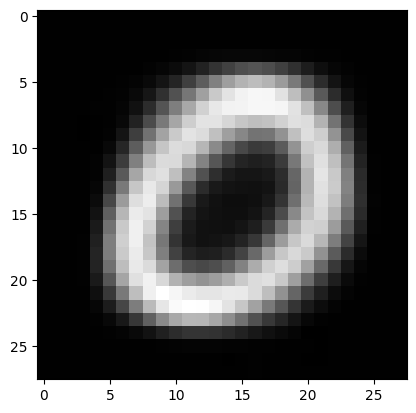

Cluster 1


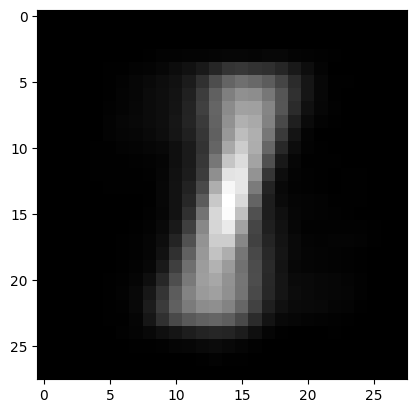

Cluster 2


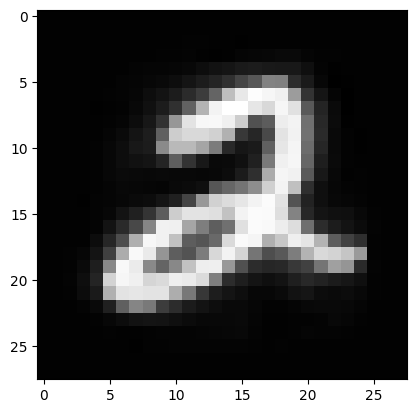

Cluster 3


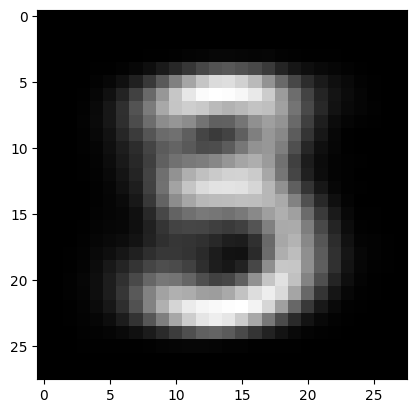

Cluster 4


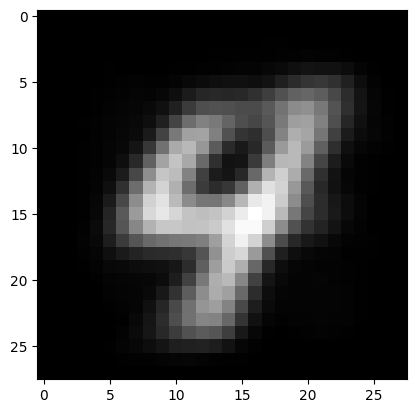

Cluster 5


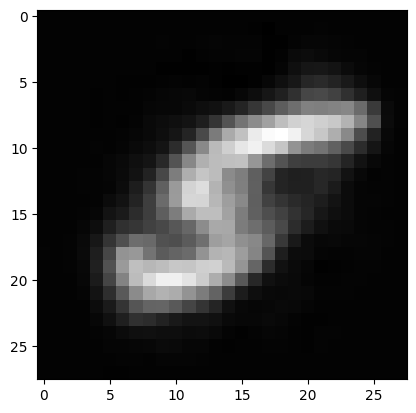

Cluster 6


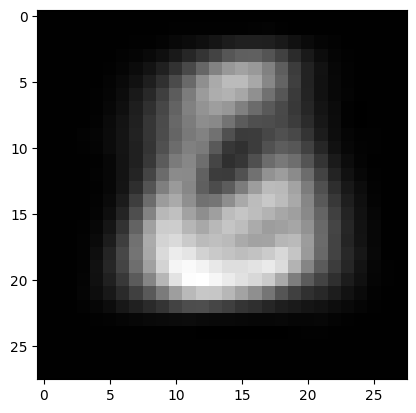

Cluster 7


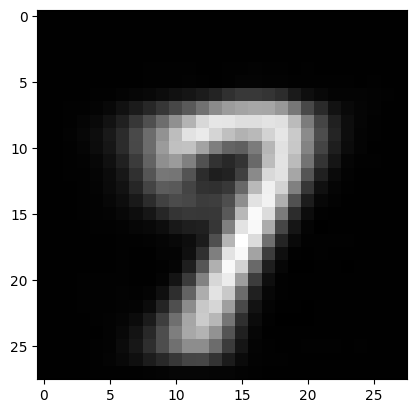

Cluster 8


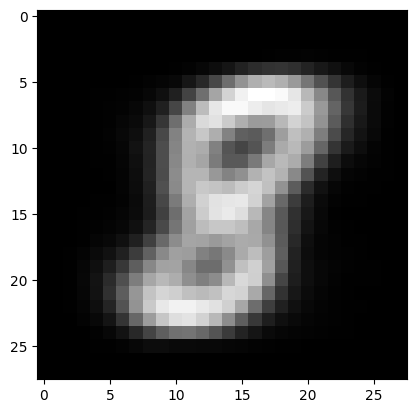

Cluster 9


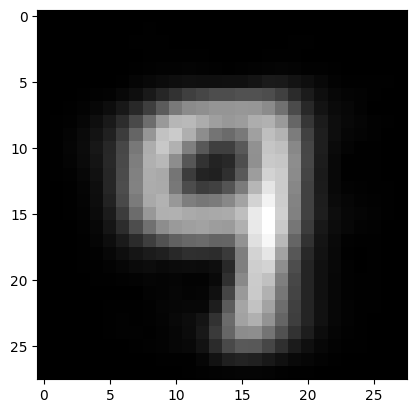

In [1]:
# *****************************************************************************
# *****************************************************************************
# k-means using a neural network
# *****************************************************************************
# *****************************************************************************

# *****************************************************************************
# Preamble and dataset loading, based on PyTorch tutorial
# *****************************************************************************
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import random
import numpy as np
import matplotlib.pyplot as plt

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

torch.set_default_device(device)
print(f"Using {device} device")

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

batch_size = 64 #!!! Fill in !!!#

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# *****************************************************************************
# Building the neural network
# *****************************************************************************
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()  #!!! Fill in !!!#
        self.centers = nn.Parameter(torch.zeros((10, 28 * 28))) #!!! Fill in !!!# Use nn.Parameter
        self.softmax = nn.Softmax(dim=1) #!!! Fill in !!!# Along dimension 1

    def forward(self, x):
        z = self.flatten(x)
        x = torch.matmul(z, self.centers.T) - 0.5 * torch.sum(self.centers ** 2, dim=1) #!!! Fill in !!!# Get surrogate for -distance
        x = 20*x
        x = self.softmax(x)
        x = torch.matmul(x, self.centers) #!!! Fill in !!!# Get center
        x = x - z #!!! Fill in !!!# Get error
        return x

model = NeuralNetwork().to(device)

# *****************************************************************************
# Train and test loops
# *****************************************************************************
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.to(device))
        loss = loss_fn(pred, torch.zeros_like(pred)) #!!! Fill in !!!# Compare the error return by the model to 0

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device))
            test_loss += loss_fn(pred, torch.zeros_like(pred)).item() #!!! Fill in !!!# Compare the error return by the model to 0
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n {size} {num_batches}")


# *****************************************************************************
# Optimization prameters and initialization
# *****************************************************************************
basic_train_dataloader = DataLoader(training_data, batch_size=1)
training_size = len(basic_train_dataloader.dataset)

loss_fn = nn.MSELoss() #!!! Fill in !!!# Mean squared error
learning_rate = 4.5 #!!! Fill in !!!#
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Initialization:
with torch.no_grad():
  # model.centers[:] = torch.zeros((10,28*28)).to(device)
  i=0
  for X, y in basic_train_dataloader:
    if y==i: # You could try randomizing whether you pick this point or not.
      model.centers[i, :] = X.view(-1) #!!! Fill in !!!# Set the i-th center to this X
      i += 1
    if i==10:
      break

# *****************************************************************************
# Standard training epochs
# *****************************************************************************
print(model)
print("Training model...")
epochs = 10 #!!! Fill in !!!#
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

# *****************************************************************************
# Building the confusion matrix
# *****************************************************************************
print("Computing the confusion matrix...")
C = model.centers.detach().cpu() # Extract the centers from the model
counts = np.zeros((10, 10)) #!!! Fill in !!!# Initialize counts matrix
with torch.no_grad():
  for X, y in basic_train_dataloader:
    best_distance = 1e16 # Very large number for initialization
    best_index = 0 # Arbitrary index for initialization
    for j in range(10):
      dist = torch.norm(X.view(-1) - C[j, :]) #!!! Fill in !!!# Calculate distance of X from center j
      if dist < best_distance: #!!! Fill in !!!# Determine condition to update the distance and index
        best_distance = dist #!!! Fill in !!!# Update the distance
        best_index = j #!!! Fill in !!!# Update the index
    counts[y.item(), best_index] += 1 #!!! Fill in !!!# Update the counts at the (label, cluster) index

print(counts.astype(int))

# *****************************************************************************
# Displaying the centers
# *****************************************************************************
print("Cluster centers:")
for j in range(10):
  print(f"Cluster {j}")
  q = C[j, :].view(28, 28)  #!!! Fill in !!!# Grab center j
  plt.imshow(q.cpu(), cmap="gray") #!!! Fill in !!!# Display center j as an image
  plt.show()

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (softmax): Softmax(dim=1)
)
Training model...
Epoch 1
-------------------------------
loss: 0.299930  [   64/60000]
loss: 0.091237  [ 6464/60000]
loss: 0.064616  [12864/60000]
loss: 0.075269  [19264/60000]
loss: 0.067146  [25664/60000]
loss: 0.067735  [32064/60000]
loss: 0.064630  [38464/60000]
loss: 0.063330  [44864/60000]
loss: 0.074017  [51264/60000]
loss: 0.065341  [57664/60000]
Avg loss: 0.067569 
 10000 157
Epoch 2
-------------------------------
loss: 0.064417  [   64/60000]
loss: 0.069046  [ 6464/60000]
loss: 0.061646  [12864/60000]
loss: 0.075336  [19264/60000]
loss: 0.067121  [25664/60000]
loss: 0.067738  [32064/60000]
loss: 0.064628  [38464/60000]
loss: 0.063329  [44864/60000]
loss: 0.074018  [51264/60000]
loss: 0.065341  [57664/60000]
Avg loss: 0.067569 
 10000 157
Epoch 3
-------------------------------
loss: 0.064417  [   64/60000]
loss: 0.069046  [ 6464/60000]
loss: 0.061646  [12864/60000]
l

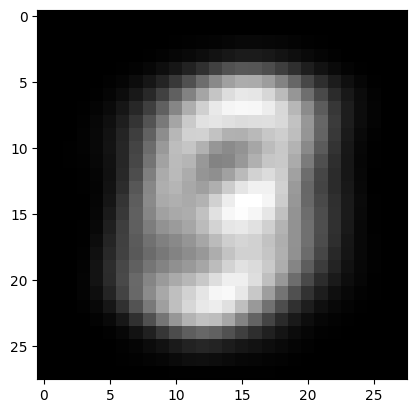

Cluster 1


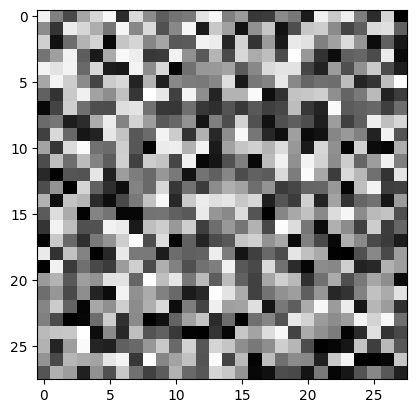

Cluster 2


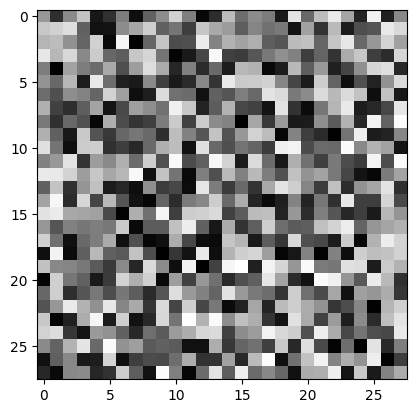

Cluster 3


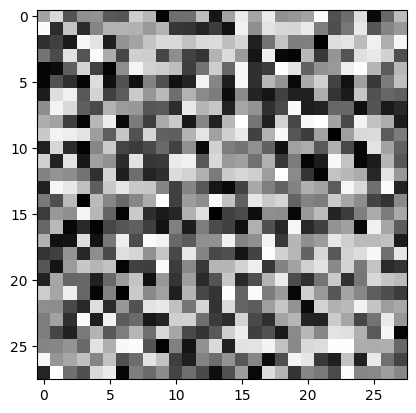

Cluster 4


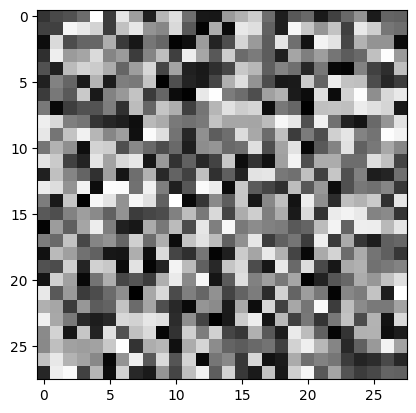

Cluster 5


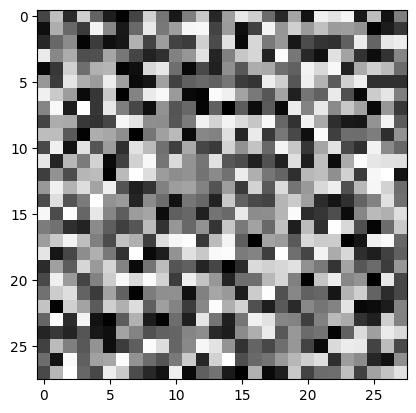

Cluster 6


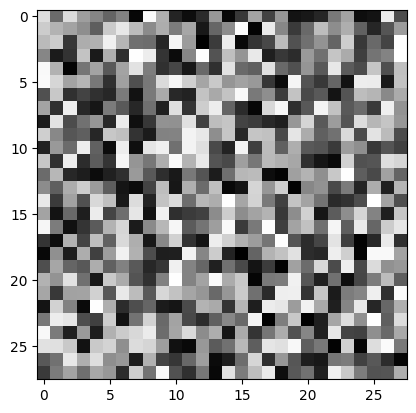

Cluster 7


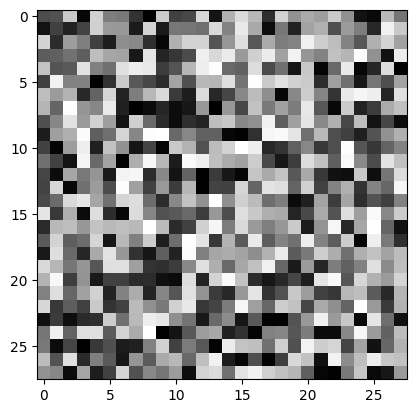

Cluster 8


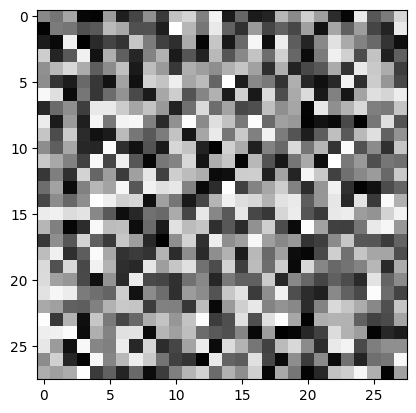

Cluster 9


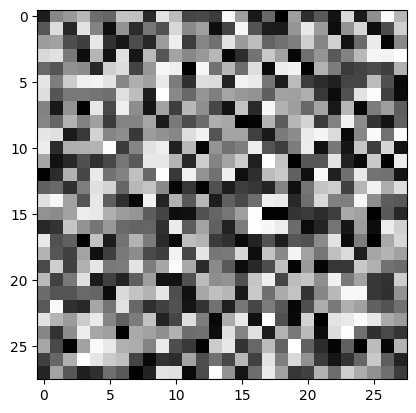

In [2]:
# *****************************************************************************
# *****************************************************************************
# k-means using a neural network
# *****************************************************************************
# *****************************************************************************

# *****************************************************************************
# Preamble and dataset loading, based on PyTorch tutorial
# *****************************************************************************
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import random
import numpy as np
import matplotlib.pyplot as plt

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

torch.set_default_device(device)
print(f"Using {device} device")

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

batch_size = 64 #!!! Fill in !!!#

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# *****************************************************************************
# Building the neural network
# *****************************************************************************
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()  #!!! Fill in !!!#
        self.centers = nn.Parameter(torch.zeros((10, 28 * 28))) #!!! Fill in !!!# Use nn.Parameter
        self.softmax = nn.Softmax(dim=1) #!!! Fill in !!!# Along dimension 1

    def forward(self, x):
        z = self.flatten(x)
        x = torch.matmul(z, self.centers.T) - 0.5 * torch.sum(self.centers ** 2, dim=1) #!!! Fill in !!!# Get surrogate for -distance
        x = 20*x
        x = self.softmax(x)
        x = torch.matmul(x, self.centers) #!!! Fill in !!!# Get center
        x = x - z #!!! Fill in !!!# Get error
        return x

model = NeuralNetwork().to(device)

# *****************************************************************************
# Train and test loops
# *****************************************************************************
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.to(device))
        loss = loss_fn(pred, torch.zeros_like(pred)) #!!! Fill in !!!# Compare the error return by the model to 0

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device))
            test_loss += loss_fn(pred, torch.zeros_like(pred)).item() #!!! Fill in !!!# Compare the error return by the model to 0
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n {size} {num_batches}")


# *****************************************************************************
# Optimization prameters and initialization
# *****************************************************************************
basic_train_dataloader = DataLoader(training_data, batch_size=1)
training_size = len(basic_train_dataloader.dataset)

loss_fn = nn.MSELoss() #!!! Fill in !!!# Mean squared error
learning_rate = 4.5 #!!! Fill in !!!#
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Initialization:


with torch.no_grad():
    model.centers[:] = torch.rand((10, 28 * 28)).to(device)  # Random initialization
# *****************************************************************************
# Standard training epochs
# *****************************************************************************
print(model)
print("Training model...")
epochs = 10 #!!! Fill in !!!#
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

# *****************************************************************************
# Building the confusion matrix
# *****************************************************************************
print("Computing the confusion matrix...")
C = model.centers.detach().cpu() # Extract the centers from the model
counts = np.zeros((10, 10)) #!!! Fill in !!!# Initialize counts matrix
with torch.no_grad():
  for X, y in basic_train_dataloader:
    best_distance = 1e16 # Very large number for initialization
    best_index = 0 # Arbitrary index for initialization
    for j in range(10):
      dist = torch.norm(X.view(-1) - C[j, :]) #!!! Fill in !!!# Calculate distance of X from center j
      if dist < best_distance: #!!! Fill in !!!# Determine condition to update the distance and index
        best_distance = dist #!!! Fill in !!!# Update the distance
        best_index = j #!!! Fill in !!!# Update the index
    counts[y.item(), best_index] += 1 #!!! Fill in !!!# Update the counts at the (label, cluster) index

print(counts.astype(int))

# *****************************************************************************
# Displaying the centers
# *****************************************************************************
print("Cluster centers:")
for j in range(10):
  print(f"Cluster {j}")
  q = C[j, :].view(28, 28)  #!!! Fill in !!!# Grab center j
  plt.imshow(q.cpu(), cmap="gray") #!!! Fill in !!!# Display center j as an image
  plt.show()